In [2]:
# Task: to predict bit coin price

# How:
#  1. taking data from btc 
# 2. using naive and tenasorflow

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates=['Date'],
                 index_col=['Date'])

In [5]:
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


<Axes: xlabel='Date'>

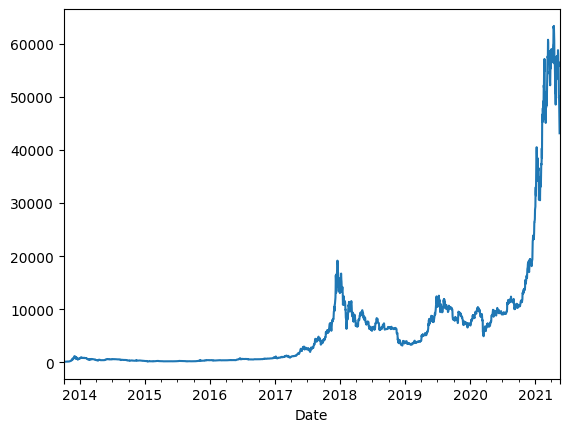

In [6]:
df['Closing Price (USD)'].plot()

In [9]:
# Creating test series

bitcoin_prices = df[['Closing Price (USD)']]
bitcoin_prices = bitcoin_prices.rename(columns={'Closing Price (USD)':'Prices'})


In [11]:
# Creating array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices.Prices.to_numpy()

In [13]:
split_size = int(0.8 * len(prices))
X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]

In [15]:
def plot_timeseries(timesteps,values,format=".",start=0,end=None,label=None):

    plt.plot(timesteps[start:end],values[start:end],format,label=label)
    plt.xlabel("Time")
    plt.ylabel("BTC Price")
    if label:
        plt.legend(fontsize=1)
    plt.grid(True)

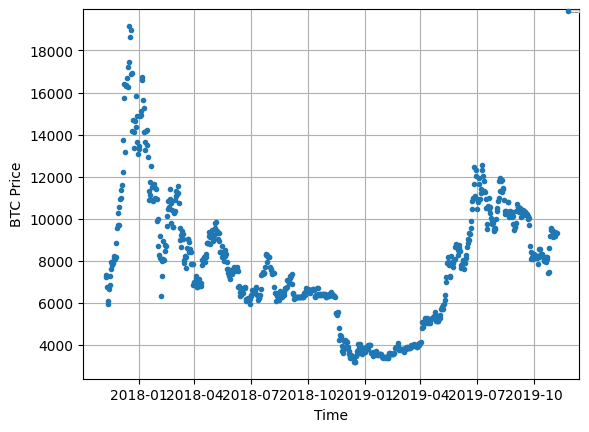

In [18]:
plot_timeseries(X_train,y_train,start=1500,label='Train data')

# Model 0: Naiive Forecast

In [21]:
naive_forecast = y_test

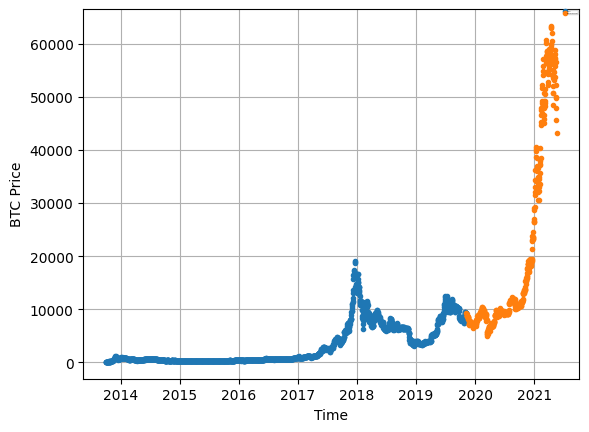

In [24]:
plot_timeseries(X_train,y_train, label="Train")
plot_timeseries(X_test,naive_forecast,label="Naive Forecast")

In [31]:
# pip install tensorflow

In [32]:
import tensorflow as tf

In [33]:
def mean_absolute_scaled_error(y_true,y_pred):
    mae = tf.reduce_mean(tf.abs(y_true,y_pred))
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_pred[:-1]))

    return mae/mae_naive_no_season

In [40]:
import sklearn

In [44]:
import sklearn.metrics


def evaluate_preds(y_true,y_pred):
    y_true = tf.cast(y_true,dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae = sklearn.metrics.mean_absolute_error(y_true,y_pred)
    mse = sklearn.metrics.mean_squared_error(y_true,y_pred)

    rmse = tf.sqrt(mse)
    mape = sklearn.metrics.mean_absolute_percentage_error(y_true,y_pred)
    mase = mean_absolute_scaled_error(y_true,y_pred)

    return {"mae":mae,
            "mse":mse,
            "rmse": rmse.numpy(),
            "mape": mape,
            "mase": mase.numpy()}

In [45]:
evaluate_preds(y_test,naive_forecast)

{'mae': 0.0, 'mse': 0.0, 'rmse': 0.0, 'mape': 0.0, 'mase': 35.312202}

In [46]:
HORIZON = 1
WINDOW_SIZE = 7

In [47]:
def get_labelled_window(x, horizon = HORIZON):
    return x[:,:-horizon],x[:,-horizon:]

In [49]:
# test_window,test_label = get_labelled_window(tf.expand_dims(tf.range(8)+1,axis=0))
# test_window,test_label

In [52]:
def make_windows(x,window_size=WINDOW_SIZE,horizon=HORIZON):
    window_step = np.expand_dims(np.arange(window_size + horizon),axis=0)
    window_index = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)),axis=0).T

    win_array = x[window_index]
    windows,label = get_labelled_window(win_array,horizon)
    return windows,label,

In [53]:
full_windows, full_labels = make_windows(prices,WINDOW_SIZE,HORIZON)

In [54]:
for i in range(3):
    print(f"Window {full_windows[i]} -> labels {full_labels[i]}")

Window [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> labels [123.033]
Window [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> labels [124.049]
Window [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> labels [125.96116]


In [56]:
def make_train_test_split(windows, labels, test_split=0.2):
    split_size = int(len(windows) * (1-test_split))

    train_windows = windows[:split_size]
    train_labels = labels[:split_size]

    test_windows = windows[split_size:]
    test_labels = labels[split_size:]

    return train_windows,train_labels,test_windows,test_labels

In [57]:
train_windows,train_labels,test_windows,test_labels = make_train_test_split(full_windows,full_labels)

In [70]:
# Make a modelling checkpoint
import os

def create_model_checkpoint(model_name,save_path = "model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path,model_name,'model.keras'),
                                              monitor ='val_loss',
                                              verbose=0,
                                              save_best_only=True)

In [71]:
# Model 1

tf.random.set_seed(42)

model_1 = tf.keras.Sequential([
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(HORIZON,activation='linear')
],name='model_1_dense')

model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae','mse'])

history1 = model_1.fit(train_windows,train_labels,
                       epochs=100,
                       verbose=1,
                       batch_size=128,
                       validation_data= (test_windows,test_labels),
                       callbacks = [create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 765.8541 - mae: 765.8541 - mse: 2001191.2500 - val_loss: 1528.1801 - val_mae: 1528.1801 - val_mse: 5663867.0000
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 223.4983 - mae: 223.4983 - mse: 220007.3438 - val_loss: 1079.1229 - val_mae: 1079.1229 - val_mse: 3258368.7500
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 163.0094 - mae: 163.0094 - mse: 134671.8906 - val_loss: 869.8708 - val_mae: 869.8708 - val_mse: 2496450.7500
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 149.7135 - mae: 149.7135 - mse: 120623.5781 - val_loss: 870.1524 - val_mae: 870.1524 - val_mse: 2385221.0000
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 148.1396 - mae: 148.1396 - mse: 112574.0859 - val_loss: 833.1556 - val_mae: 833.1556 - val_mse: 2232576.0000
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 143.0394 - mae: 143.0394 - mse: 107121.0938 - val_loss: 792.3132 - val_mae: 792.3132 - val_mse:

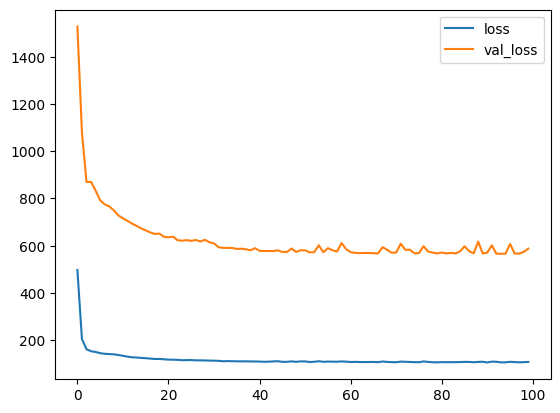

In [78]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.legend(['loss','val_loss'])

In [79]:
#Make preds
def make_preds(model,input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

In [80]:
model_1_preds = make_preds(model_1,test_windows)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [81]:
evaluate_preds(test_labels,model_1_preds)

{'mae': 587.8802,
 'mse': 1209879.8,
 'rmse': 1099.9453,
 'mape': 0.026633646,
 'mase': 1.1680791}

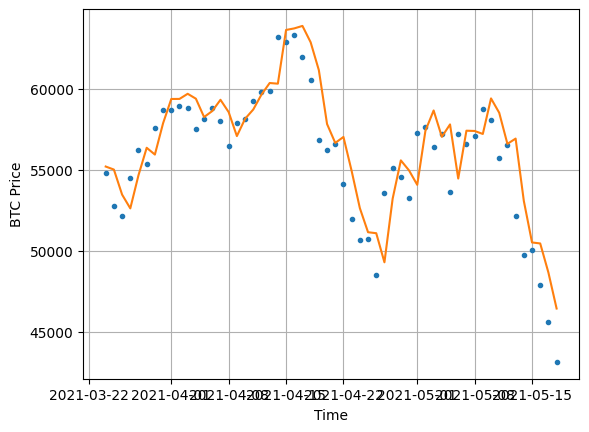

In [104]:
plot_timeseries(X_test[-len(test_windows):],test_labels[:,0],start=500)
plot_timeseries(X_test[-len(test_windows):],model_1_preds,format='-',start=500)

In [85]:
# Model 2: Using conv1D

In [88]:
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=1)),
    tf.keras.layers.Conv1D(filters=128,kernel_size=3,strides=1,padding="causal",activation='relu'),
    tf.keras.layers.Dense(HORIZON)
],name='model_2')

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

history2 = model_2.fit(train_windows,train_labels,
                       epochs=100,
                       batch_size=100,
                       verbose=0,
                       validation_data = (test_windows, test_labels),
                       callbacks = [create_model_checkpoint(model_name=model_2.name)])

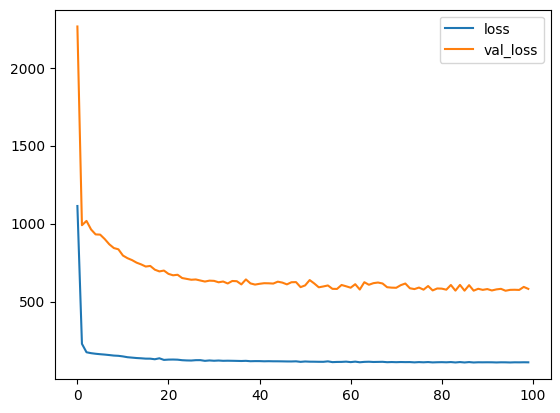

In [89]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['loss','val_loss'])

In [90]:
model_2_preds = make_preds(model_2,test_windows)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [92]:
evaluate_preds(test_labels,model_2_preds)

{'mae': 581.01886,
 'mse': 1202436.0,
 'rmse': 1096.5564,
 'mape': 0.02614484,
 'mase': 1.1693261}

Text(0.5, 1.0, 'Model 2')

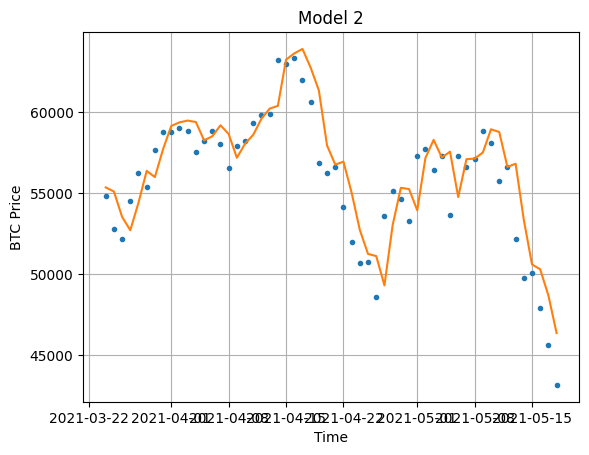

In [103]:
plot_timeseries(X_test[-len(test_windows):],test_labels[:,0],start=500)
plot_timeseries(X_test[-len(test_windows):],model_2_preds,format='-',start=500)
plt.title("Model 2")

In [94]:
# Model 3: LSTM Model

In [97]:
tf.random.set_seed(37)

inputs = tf.keras.layers.Input(shape=(WINDOW_SIZE,))
x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=1))(inputs)
x = tf.keras.layers.LSTM(128,activation='relu')(x)
output = tf.keras.layers.Dense(HORIZON)(x)

model_3 = tf.keras.Model(inputs,output,name = "model_3_LSTM")

model_3.compile(loss="mae",
                optimizer = tf.keras.optimizers.Adam())

history3 = model_3.fit(train_windows,train_labels,
                       epochs=100,
                       batch_size=100,
                       verbose=0,
                       validation_data = (test_windows, test_labels),
                       callbacks = [create_model_checkpoint(model_name=model_3.name)])

In [98]:
model_3_preds = make_preds(model_3,test_windows)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Text(0.5, 1.0, 'Model 3')

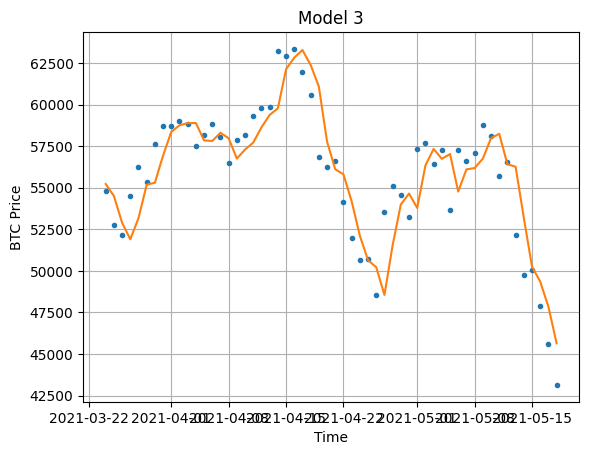

In [102]:
plot_timeseries(X_test[-len(test_windows):],test_labels[:,0],start=500)
plot_timeseries(X_test[-len(test_windows):],model_3_preds,format='-',start=500)
plt.title("Model 3")